## Initialisation 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, LeakyReLU, Dropout, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Embedding, Input, Concatenate, GlobalAveragePooling2D, UpSampling2D
from keras.models import load_model
from keras.optimizers import Adamax, Adam
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal

from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Kaggle
for running this code, we need to import the dataset from the [Kaggle Website](https://kaggle.com/). 

1.   Sign up in [Kaggle](https://kaggle.com/) (or if you have an account, sign in)
2.   Go to account > Create New API Token
3.   Download your kaggle.json file and upload it here.
4.   Run the code below





In [3]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 74 Apr 10 14:01 kaggle.json


In [4]:
import kaggle


dataset_dir = '/content/CelebA'


def download_celabA(dataset_dir):
    """
    Downloads CelebA dataset from Kaggle and loads it in dataset_dir.
    """
    if not os.path.exists(dataset_dir):
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files(dataset="jessicali9530/celeba-dataset", path=dataset_dir, unzip=True)
        print('Download completed.')
    else:
        print('CelebA dataset already exists.')
    
    return True

download_celabA(dataset_dir)

Download completed.


True

and finally, adress the files we have downloaded and set our latent dimension.

In [5]:
ATTRIBUTE_PATH = '/content/CelebA/list_attr_celeba.csv'
FACES_PATH     = '/content/CelebA/img_align_celeba/img_align_celeba'
latent_dim     = 128
batch_num      = 128

## Convolutional Generative Adversarial Networks (CGANs)
In this project, we want to use Generative Adversarial Networks (GANs), as we know, we have two Neural Network contest with each other in a game (Generator and Discriminator) The generative network generates candidates while the discriminative network evaluates them. During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart.

### Discriminator
First we create our descriminator. As we said before, Discriminator has to evaluate the generator output and distinguish candidates from the true data distribution. 
Here, we have images which they are 64x64 pixels, and two classes, True(real) or False(fake).


In [7]:
def discriminator(in_shape=(64, 64, 3), n_classes=2):
  n_nodes = in_shape[0] * in_shape[1]  
  # Label Input
  in_label = Input(shape=(40,))
  # Embedding for categorical input
  li = Embedding(n_classes, 128)(in_label)
  # Flatten the Labels Embedding
  li = Flatten()(li)
  # Scale Up to image dimensions with linear activation
  li = Dense(n_nodes)(li)
  li = LeakyReLU(alpha=0.2)(li)
  # Reshape to additional Channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # Concatenate labels as a channel to image
  merge = Concatenate()([in_image, li])
  # Downsample to 32*32
  fe = Conv2D(32, (5, 5), strides=(2, 2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # Downsample to 16*16
  fe = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # Downsample to 8*8
  fe = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # Downsample to 4*4
  fe = Conv2D(256, (5, 5), strides=(2, 2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # Flatten feature map
  fe = Flatten()(fe)
  # Dropout
  fe = Dropout(0.4)(fe)
  # Output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # Define Mode
  model = Model([in_image, in_label], out_layer)
  # Compile Model using Adam optimizer
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

#### Plot the Discriminator Model

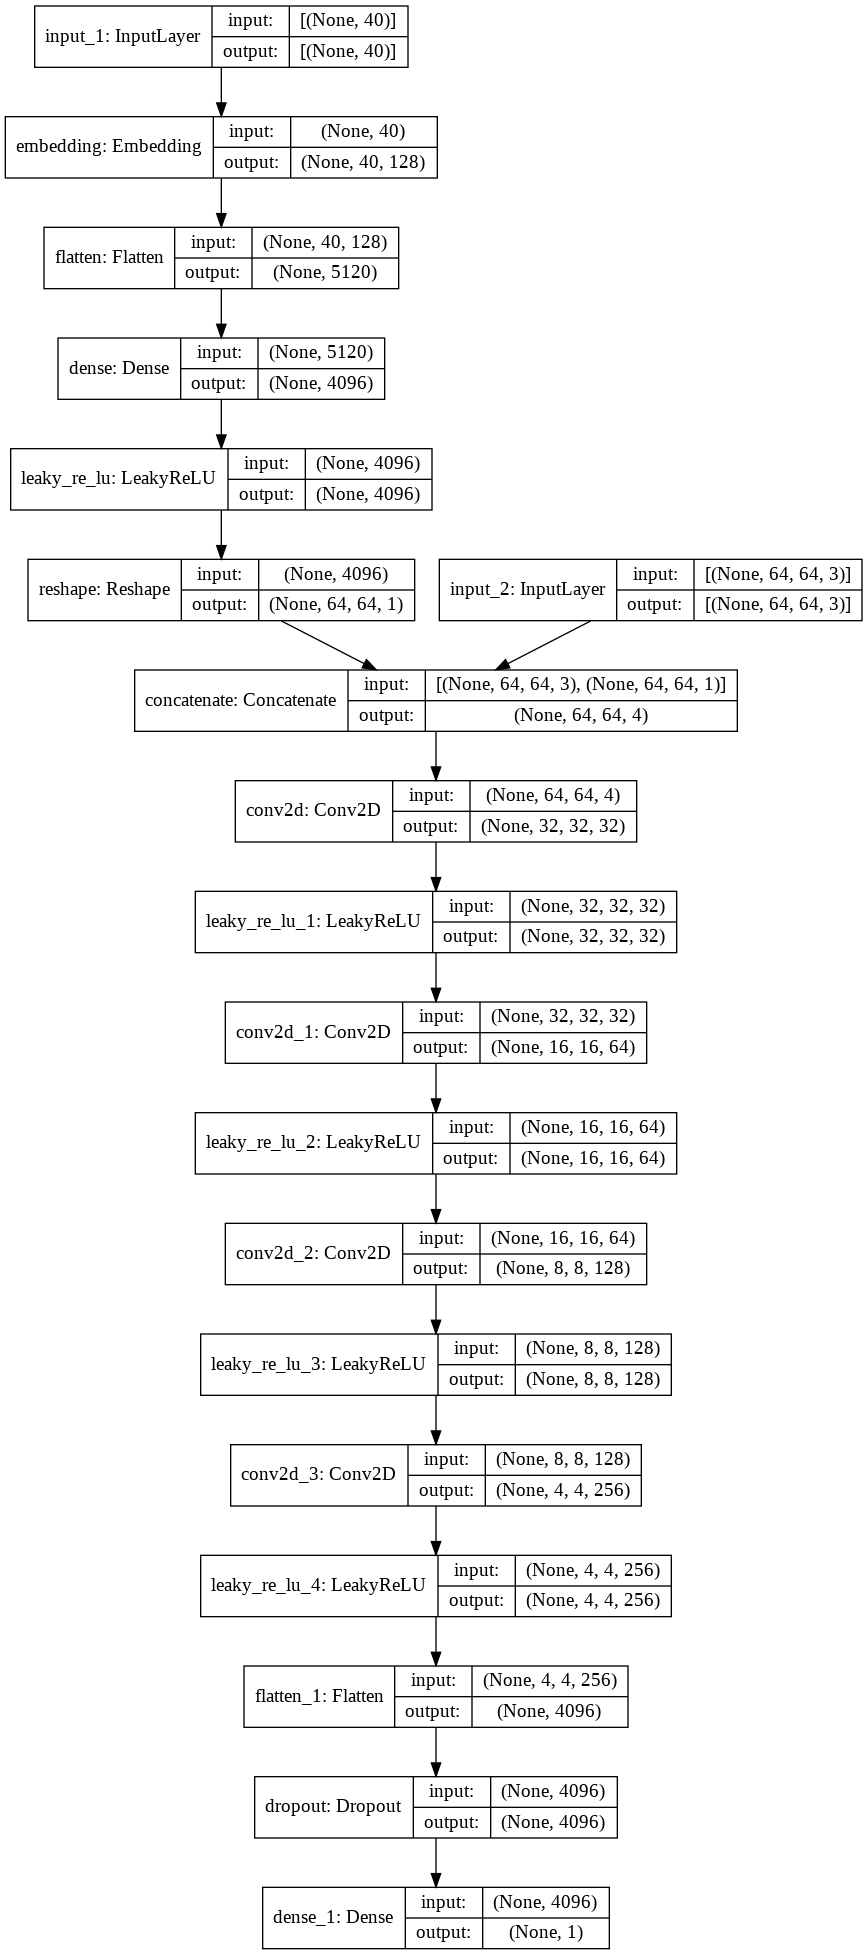

In [8]:
plot_model(discriminator(), to_file='discriminator.png', show_shapes=True)

### Generator
The generator, typically, learns to map from a latent space to a data distribution of interest. The generative network's training objective is to increase the error rate of the discriminative network (i.e., "fool" the discriminator network by producing novel candidates that the discriminator thinks are not synthesized (are part of the true data distribution))

In [9]:
def generator(latent_dim, n_classes=2):
  # Label input
  in_label = Input(shape=(40,))
  # embedding for categorical input
  li = Embedding(n_classes, 128)(in_label)
  # Linear Multiplication
  li = Flatten()(li)
  n_nodes = 4 * 4
  li = Dense(n_nodes)(li)
  li = LeakyReLU(alpha=0.2)(li)
  # Reshape to additional channel
  li = Reshape((4, 4, 1))(li)
  # Image generation input
  in_lat = Input(shape=(latent_dim,))
  # Fundation for 4x4 image
  n_nodes = 128 * 4 * 4
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((4, 4, 128))(gen)
  # Merge image gen and label input
  merge = Concatenate()([gen, li])
  # Upsample to 8x8
  gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Upsample to 16x16
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Upsample to 32x32
  gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same',)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Upsample to 64x64
  gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Output
  out_layer = Conv2D(3, (5, 5), activation='tanh', padding='same')(gen)
  # Define Model
  model = Model([in_lat, in_label], out_layer)
  return model

#### Plot the Generator Model

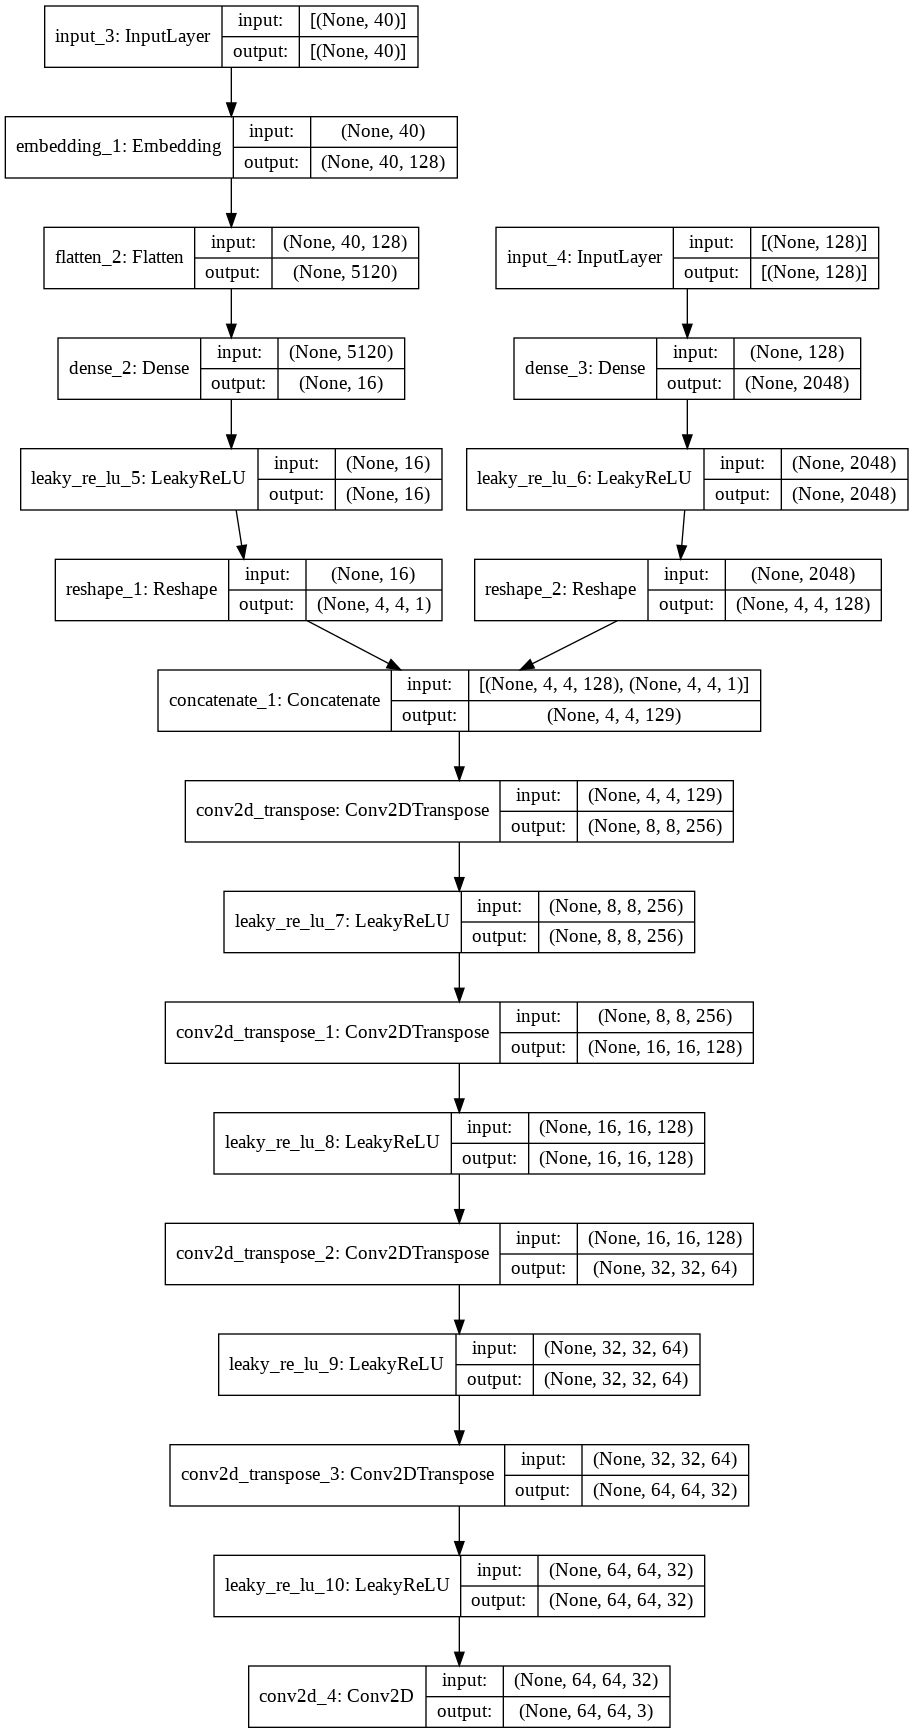

In [10]:
plot_model(generator(latent_dim= latent_dim), to_file='generator.png', show_shapes=True)

### GAN Model
well, now we generate our GAN model.

In [11]:
def gan(g_model, d_model):
  # Make weights in discriminator untrainable
  d_model.trainable = False
  # Get noise and label inputs from generator model
  gen_noise, gen_label = g_model.input
  # Get image output from the generation
  gen_output = g_model.output
  # Connect image output and label input from generator as inputs to discriminator
  gan_output = d_model([gen_output, gen_label])
  # Define gan model as taking noise and label and outpurring a classification
  model = Model([gen_noise, gen_label], gan_output)
  # Compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

and let's have a look at our model.

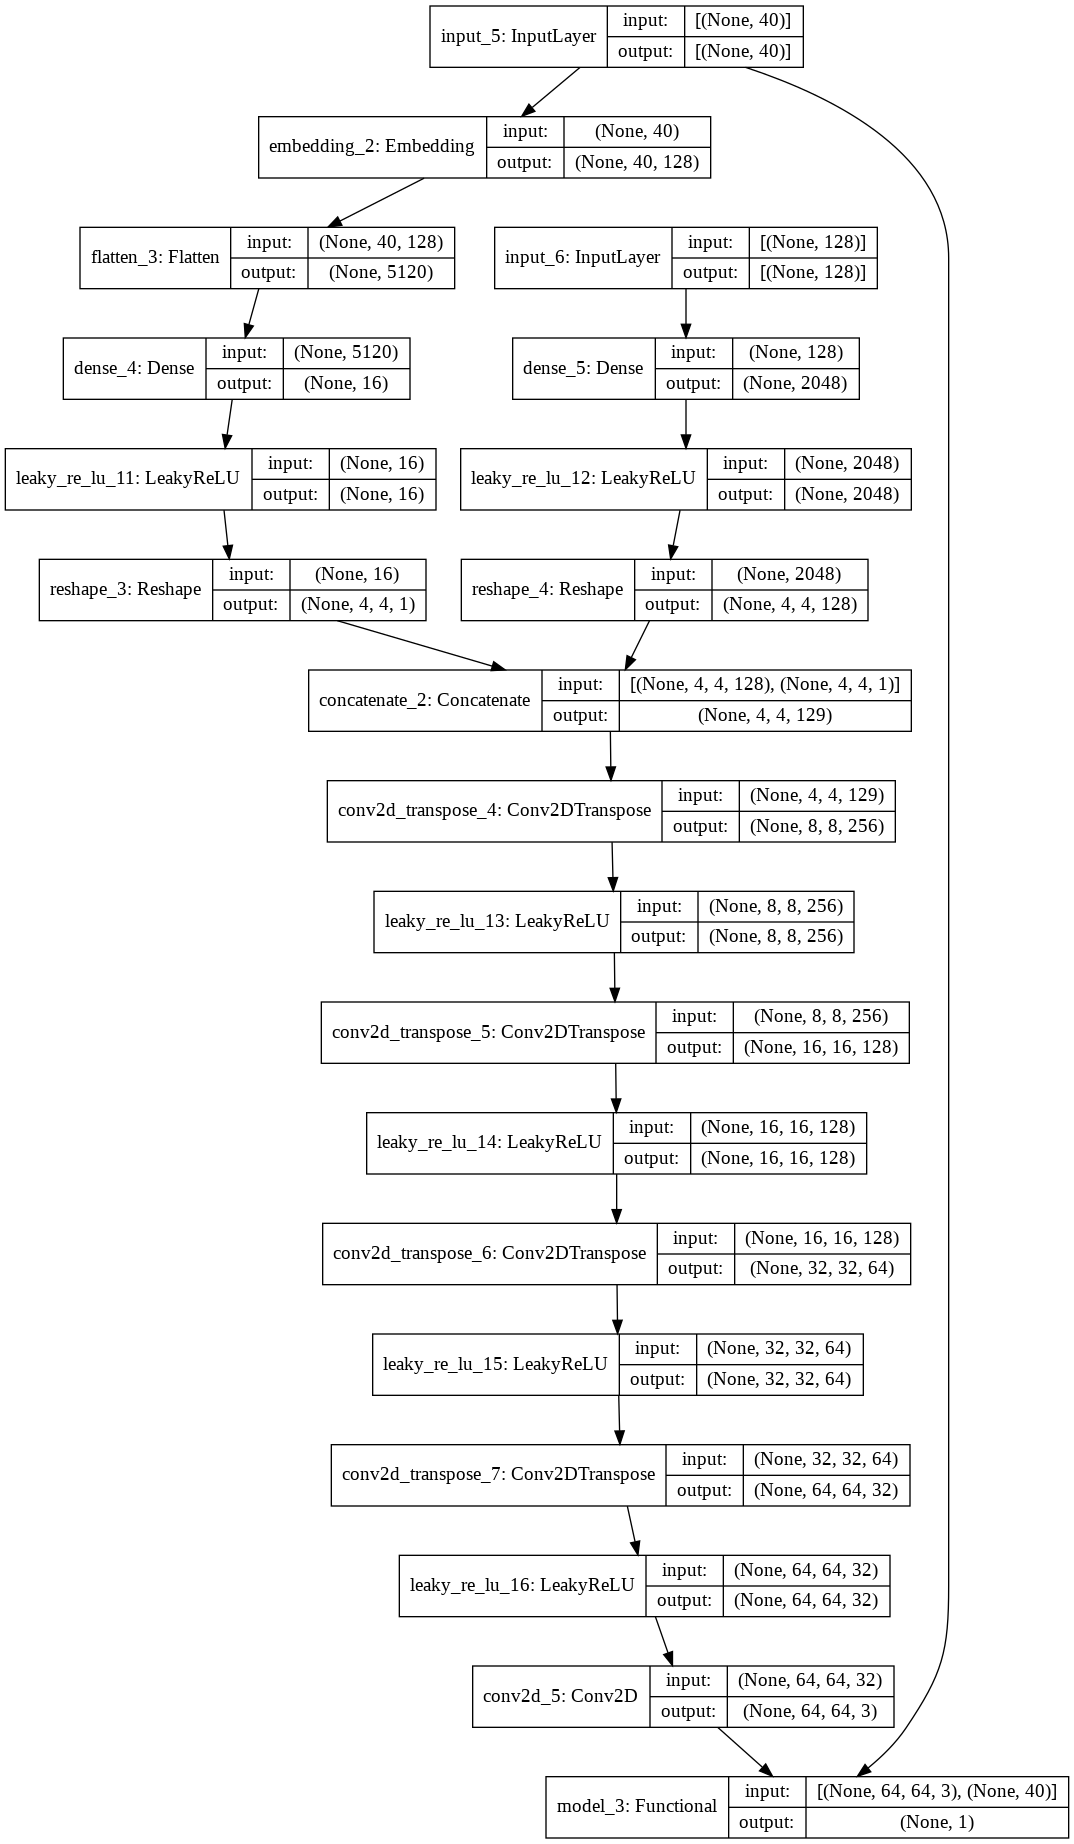

In [12]:
plot_model(gan(generator(latent_dim= latent_dim), discriminator()), to_file='gan.png', show_shapes=True)

### Loading Real Samples With Its Attributes
In this section we generate random real sample with its attributes
While choosing randmoly beetween real sample simltinusly we crop images and make ready for our network.

In [6]:
def real_samples_generator(faces_path, attribute_path, batch_size):
  att = pd.read_csv(attribute_path, index_col='image_id')[:180000]
  while True:
    
    batch_info = np.random.choice(att.index, batch_size, replace=False)
    images_batch = []

    for image_info in batch_info:
      img = Image.open(faces_path + '/' + image_info)
      img = img.crop((25, 45, 153, 173))
      img = img.resize((64, 64))
      img = img.convert('RGB')
      img = np.asarray(img)
      img = img.astype('float32')
      img = (img - 127.5) / 127.5 # Normalization to [-1.,1.]
      images_batch.append(img)

    img_att = np.array(att.loc[batch_info].replace(to_replace=-1, value=0), dtype=np.float32)
    images_batch = np.array(images_batch, dtype=np.float32)
    y = np.ones((batch_size, 1))
    yield [images_batch, img_att, y]

### Generating Latent Point And Fake Samples



In [7]:
def generate_latent_point(latent_dim, n_samples, n_classes=2):
  # generate points in the latent space
  X_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = X_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.random.randint(0, n_classes, (n_samples, 40))
  return [z_input, labels]


def generate_fake_samples(generator, latent_dim, real_labels, n_samples):
  # Generate point in Latent Space
  z_input , labels_input = generate_latent_point(latent_dim, n_samples)
  # Pridect Output
  z = np.concatenate((z_input, real_labels), axis=1)
  images = generator.predict([z_input, real_labels])
  #images = generator.predict(z)
  # Create_class_labels
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y

### Plotting Section
define the plot method for saving the results of each batch.

In [8]:
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, epoch):
    # plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d_real')
    plt.plot(d2_hist, label='d_fake')
    plt.plot(g_hist, label='gan')
    plt.legend()
    # plot Discriminator
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc_real')
    plt.plot(a2_hist, label='acc_fake')
    plt.legend()

    directory = '/content/drive/MyDrive/Plot_History/'
    if os.path.exists(directory):
      plt.savefig('/content/drive/MyDrive/Plot_History/cgan_CelebA_plot_line_plot_loss_{}.png'.format(epoch+1))
    else:
      os.makedirs(directory)
      plt.savefig('/content/drive/MyDrive/Plot_History/cgan_CelebA_plot_line_plot_loss_{}.png'.format(epoch+1))
    plt.close()


def show_plot(g_model, real_labels, latent_dim, n_samples=25):
    [images, _], _ = generate_fake_samples(g_model, latent_dim, real_labels[:25], n_samples)
    examples = (images + 1) / 2.0
    for i in range(5 * 5):
        plt.subplot(5, 5, 1+i)
        plt.axis('off')
        plt.imshow(examples[i])
    plt.show()

### Train Generator and Discriminator
For our discrminator we use half batch images for train it. Because our discrimnator train for both real and fake images.
While our GAN train for full batch number of images.

In [9]:
disc_training_set = real_samples_generator(FACES_PATH, ATTRIBUTE_PATH, int(batch_num/2))
gen_training_set  = real_samples_generator(FACES_PATH, ATTRIBUTE_PATH, batch_num)

In [17]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=40, n_batch=batch_num):
  bat_per_epo = int(180000 / n_batch)
  half_batch = int(n_batch / 2)
  d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
  # Enumrating epochs
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      # get randomly selected real samples
      X_real, label_real, y_real = next(disc_training_set)
      # update discriminator model weights
      d_loss1, d_acc1 = d_model.train_on_batch([X_real, label_real], y_real)
      # Generate Fake Samples
      [X_fake, _], y_fake = generate_fake_samples(g_model, latent_dim, label_real, half_batch)
      # Update discriminator model weights
      d_loss2, d_acc2 = d_model.train_on_batch([X_fake, label_real], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, _] = generate_latent_point(latent_dim, n_batch)
      # prepare real labels for gan
      _, z_label, _ = next(gen_training_set)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, z_label], y_gan)

      # Taking history of Loss and accuracy of model
      d1_hist.append(d_loss1)
      d2_hist.append(d_loss2)
      g_hist.append(g_loss)
      a1_hist.append(d_acc1)
      a2_hist.append(d_acc2)
      if (j+1) % 100 == 0:
        print('Epochs->{} / Batch->{}'.format(i+1, j+1))
        show_plot(g_model, label_real, latent_dim)
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, i)
  g_model.save('cgan_generator.h5')

Training started! There are 2 epochs in the queue... Be patient...
Epochs->1 / Batch->100


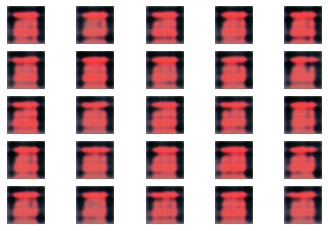

Epochs->1 / Batch->200


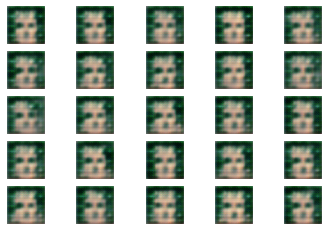

Epochs->1 / Batch->300


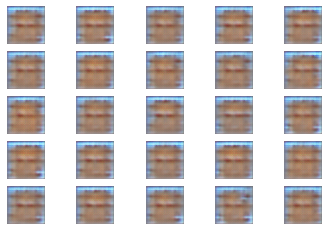

Epochs->1 / Batch->400


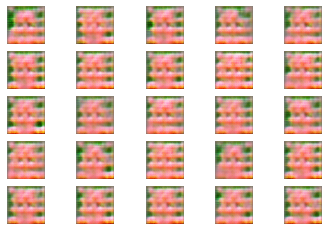

Epochs->1 / Batch->500


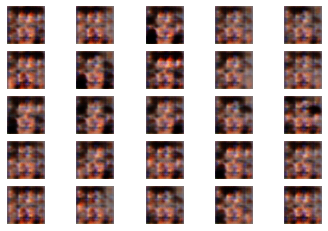

Epochs->1 / Batch->600


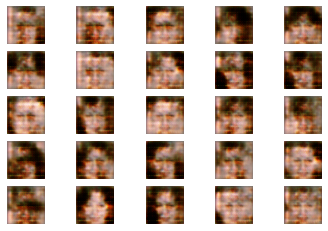

Epochs->1 / Batch->700


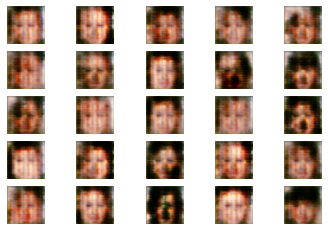

Epochs->1 / Batch->800


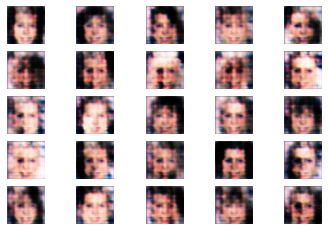

Epochs->1 / Batch->900


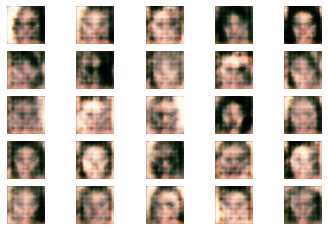

Epochs->1 / Batch->1000


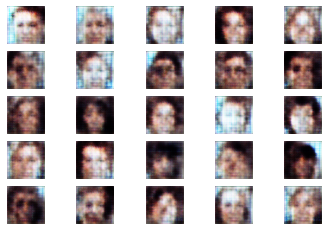

Epochs->1 / Batch->1100


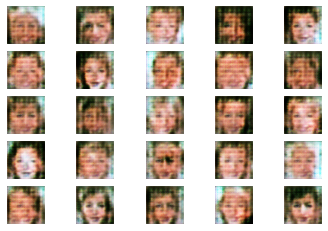

Epochs->1 / Batch->1200


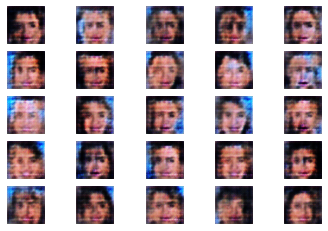

Epochs->1 / Batch->1300


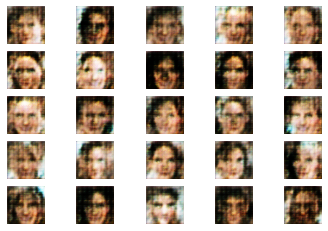

Epochs->1 / Batch->1400


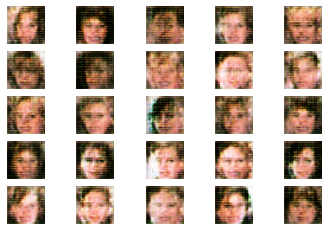

Epochs->2 / Batch->100


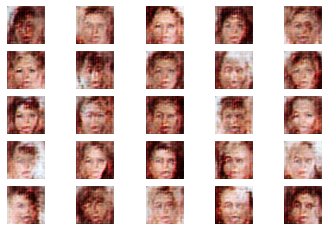

Epochs->2 / Batch->200


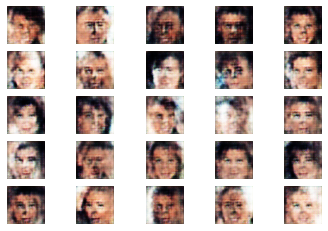

Epochs->2 / Batch->300


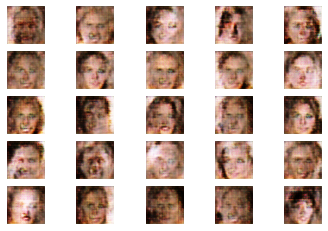

Epochs->2 / Batch->400


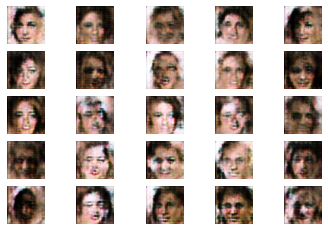

Epochs->2 / Batch->500


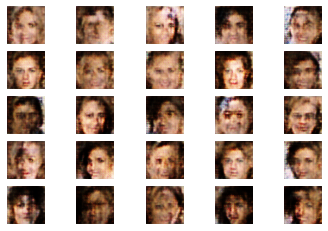

Epochs->2 / Batch->600


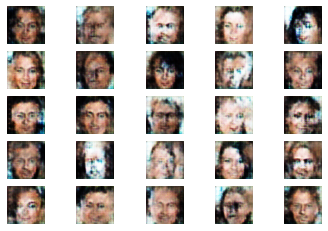

Epochs->2 / Batch->700


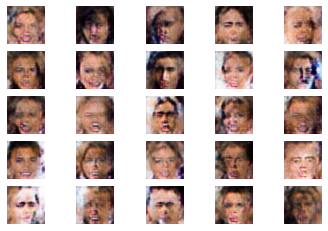

Epochs->2 / Batch->800


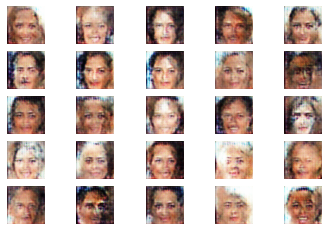

Epochs->2 / Batch->900


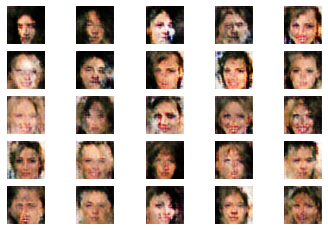

Epochs->2 / Batch->1000


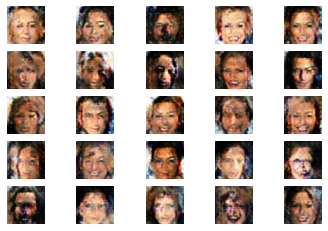

Epochs->2 / Batch->1100


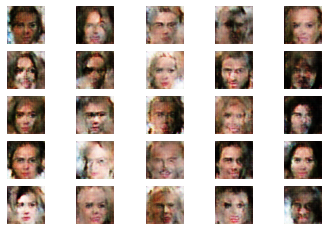

Epochs->2 / Batch->1200


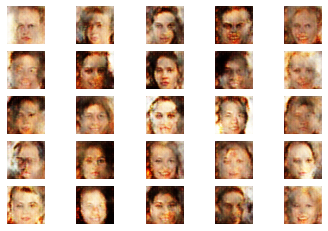

Epochs->2 / Batch->1300


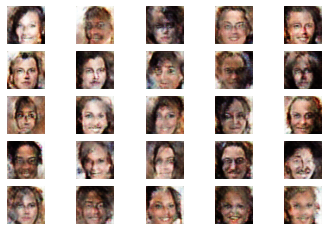

Epochs->2 / Batch->1400


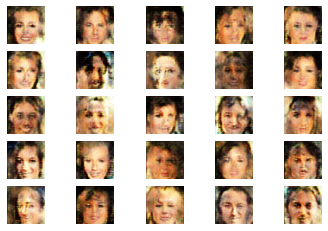

In [ ]:
# Number of epoches
n_epochs = 40
d_model = discriminator()
g_model = generator(latent_dim=latent_dim)
gan_model = gan(g_model, d_model)
print('Training started! There are {} epochs in the queue... Be patient...'.format(n_epochs))
train(g_model, d_model, gan_model, latent_dim=latent_dim, n_epochs=n_epochs)

### Testing  Section

In [57]:
n_sample = 25

[z_input, labels_input] = generate_latent_point(latent_dim, n_sample)
att = pd.read_csv(ATTRIBUTE_PATH, index_col='image_id')[:n_sample]
# replace -1 with 0, because we considered in the code 0 as false and 1 as true
att = att.replace(to_replace=-1, value=0)

def plot_generated(examples, n):
  # plot images
  plt.figure(figsize=(10, 10))
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :])
  plt.show()

Choose your custum attribute from form below for generating new Faces.

In [46]:
#@title Gender

Male = False #@param {type:"boolean"}
att['Male'] = int(Male)

In [28]:
#@title Age
Young = True #@param {type:"boolean"}
att['Young'] = int(Young)

In [52]:
#@title Hair Color

Bald = False #@param {type:"boolean"}
att['Bald'] = int(Bald)

Black_Hair = False #@param {type:"boolean"}
att['Black_Hair'] = int(Black_Hair)

Blonde_Hair = False #@param {type:"boolean"}
att['Blond_Hair'] = int(Blonde_Hair)

Brown_Hair = False #@param {type:"boolean"}
att['Brown_Hair'] = int(Brown_Hair)

Gray_Hair = False #@param {type:"boolean"}
att['Gray_Hair'] = int(Gray_Hair)

In [ ]:
#@title Hair

Receding_Hairline = False #@param {type:"boolean"}
att['Receding_Hairline'] = int(Receding_Hairline)

Sideburns =  False #@param {type:"boolean"}
att['Sideburns'] = int(Sideburns)

Bangs = False #@param {type:"boolean"}
att['Bangs'] = int(Bangs)

Straight_Hair = False #@param {type:"boolean"}
att['Straight_Hair'] = int(Straight_Hair)

Wavy_Hair = False #@param {type:"boolean"}
att['Wavy_Hair'] = int(Wavy_Hair)

In [ ]:
#@title Face
Chubby = False #@param {type:"boolean"}
att['Chubby'] = int(Chubby)

Double_Chin = False #@param {type:"boolean"}
att['Double_Chin'] = int(Double_Chin)

High_Cheekbones = False #@param {type:"boolean"}
att['High_Cheekbones'] = int(High_Cheekbones)

Oval_Face = False #@param {type:"boolean"}
att['Oval_Face'] = int(Oval_Face)

Pale_Skin = False #@param {type:"boolean"}
att['Pale_Skin'] = int(Pale_Skin)

Rosy_Cheeks = False #@param {type:"boolean"}
att['Rosy_Cheeks'] = int(Rosy_Cheeks)

Attractive = False #@param {type:"boolean"}
att['Attractive'] = int(Attractive)

In [55]:
#@title Eyes
Narrow_Eyes = False #@param {type:"boolean"}
att['Narrow_Eyes'] = int(Narrow_Eyes)

Arched_Eyebrows = False #@param {type:"boolean"}
att['Arched_Eyebrows'] = int(Arched_Eyebrows)

Bushy_Eyebrows = False #@param {type:"boolean"}
att['Bushy_Eyebrows'] = int(Bushy_Eyebrows)

Eyeglasses = True #@param {type:"boolean"}
att['Eyeglasses'] = int(Eyeglasses)

Bags_Under_Eyes = False #@param {type:"boolean"}
att['Bags_Under_Eyes'] = int(Bags_Under_Eyes)

In [ ]:
#@title Nose
Big_Nose = False #@param {type:"boolean"}
att['Big_Nose'] = int(Big_Nose)

Pointy_Nose = False #@param {type:"boolean"}
att['Pointy_Nose'] = int(Pointy_Nose)

In [60]:
#@title Mouth
Big_Lips = False #@param {type:"boolean"}
att['Big_Lips'] = int(Big_Lips)

Mouth_Slightly_Open = True #@param {type:"boolean"}
att['Mouth_Slightly_Open'] = int(Mouth_Slightly_Open)

Smiling = True #@param {type:"boolean"}
att['Smiling'] = int(Smiling)

In [ ]:
#@title Facial Hair
Goatee = False #@param {type:"boolean"}
att['Goatee'] = int(Goatee)

Mustache = False #@param {type:"boolean"}
att['Mustache'] = int(Mustache)

No_Beard = True #@param {type:"boolean"}
att['No_Beard'] = int(No_Beard)

In [ ]:
#@title Makeup
Heavy_Makeup = False #@param {type:"boolean"}
att['Heavy_Makeup'] = int(Heavy_Makeup)

Wearing_Lipstick = False #@param {type:"boolean"}
att['Wearing_Lipstick'] = int(Wearing_Lipstick)

In [ ]:
#@title Accessories
Wearing_Earrings = False #@param {type:"boolean"}
att['Wearing_Earrings'] = int(Wearing_Earrings)

Wearing_Hat = False #@param {type:"boolean"}
att['Wearing_Hat'] = int(Wearing_Hat)

Wearing_Necklace = False #@param {type:"boolean"}
att['Wearing_Necklace'] = int(Wearing_Necklace)

Wearing_Necktie = False #@param {type:"boolean"}
att['Wearing_Necktie'] = int(Wearing_Necktie)

In [ ]:
#@title Others
Five_o_Clock_Shadow = False #@param {type:"boolean"}
att['Five_o_Clock_Shadow'] = int(Five_o_Clock_Shadow)

Blurry = False #@param {type:"boolean"}
att['Blurry'] = int(Blurry)

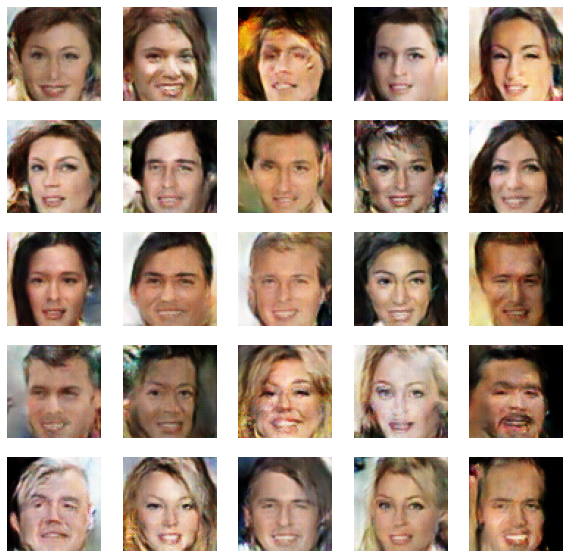

In [61]:
model = load_model('/content/drive/MyDrive/cgan_generator.h5')
X = model.predict([z_input, att])
X = (X + 1) / 2.0

# 5 is SQRT(n_Samples)
''' If you change Nnumber of sample you should change it here too'''
plot_generated(X, 5)

## AC_GAN

### Discriminator
Here we want to use another GAN model (ACGANs). Here is our discriminator again.

In [10]:
def discriminator(in_shape=(64, 64, 3), n_classes=2):
  in_image = Input(shape=in_shape)
  # Sownsample to 32*32
  fe = Conv2D(32, (5, 5), strides=(2, 2), padding='same')(in_image)
  # fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # fe = Dropout(0.5)(fe)
  # Downsample to 16*16
  fe = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(fe)
  # fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # fe = Dropout(0.5)(fe)
  # Downsample to 8*8
  fe = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(fe)
  # fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # fe = Dropout(0.5)(fe)
  # Downsample to 4*4
  fe = Conv2D(256, (5, 5), strides=(2, 2), padding='same')(fe)
  # fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # fe = Dropout(0.5)(fe)
  # Flatten feature map
  fe = GlobalAveragePooling2D()(fe)
  # fe = Flatten()(fe)
  # Dropout
  fe = Dropout(0.4)(fe)
  # Output
  out_layer1 = Dense(1, activation='sigmoid')(fe)

  # label_out = Dense(80)(fe)
  # out_layer2 = Reshape((40, 2))(label_out)
  out_layer2 = Dense(40, activation='sigmoid')(fe)
  # print(out_layer2)
  # out_layer2 = Reshape((40,))(out_layer2)
  # Define Mode
  model = Model(in_image, [out_layer1, out_layer2])
  #Compile Model
  opt = Adam(learning_rate=0.0002, beta_1=0)
  model.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=opt)
  return model

#### Plot the Discriminator Model

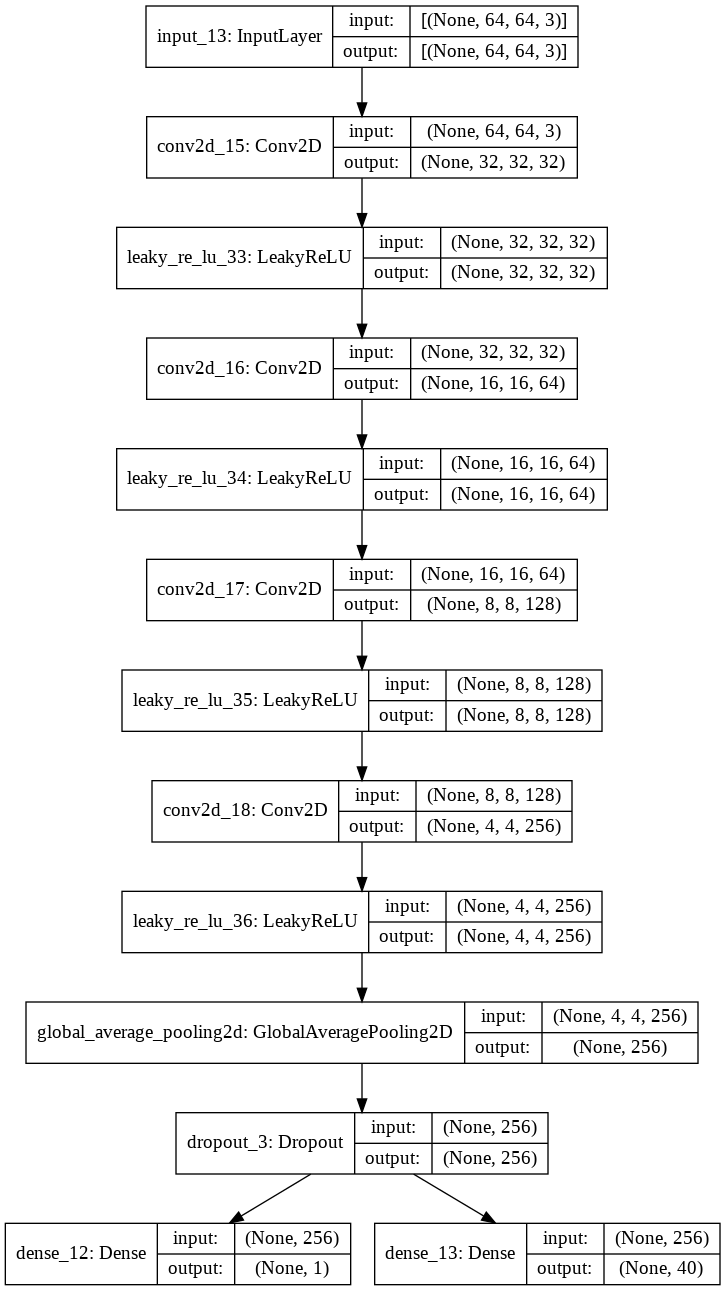

In [ ]:
plot_model(discriminator(), to_file='discriminator.png', show_shapes=True)

### Generator

In [11]:
def generator(latent_dim, n_classes=2):
  # Label input
  init = RandomNormal(stddev=0.02)
  in_att = Input(shape=(latent_dim + 40, ))
  gen = Dense(2048)(in_att)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Dropout(0.2)(gen)

  n_nodes = 256 * 8 * 8
  gen = Dense(n_nodes)(gen)
  gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Dropout(0.2)(gen)
  
  gen = Reshape((8, 8, 256))(gen)
  gen =  Conv2DTranspose(128, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  gen = BatchNormalization(momentum=0.8)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Upsample to 32*32
  gen = Conv2DTranspose(128, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  gen = BatchNormalization(momentum=0.8)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # # Upsample to 64x64
  gen = Conv2DTranspose(64, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  gen = BatchNormalization(momentum=0.8)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Output
  out_layer = Conv2D(3, (5, 5), activation='tanh', padding='same', kernel_initializer=init)(gen)
  # Define Model
  model = Model(in_att, out_layer)
  return model

#### Plot the Generator Model

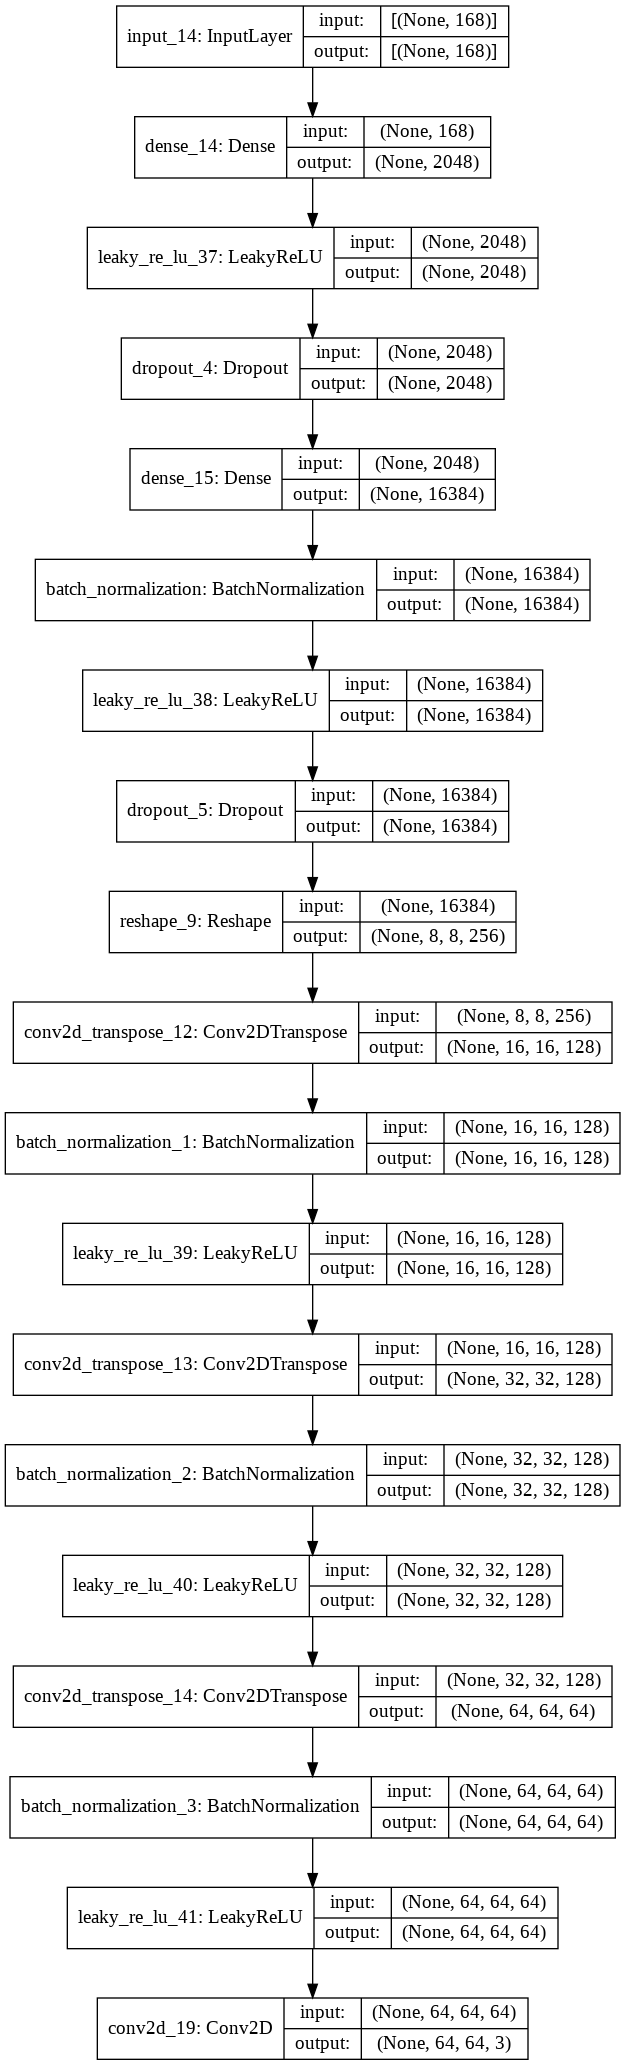

In [ ]:
plot_model(generator(latent_dim), to_file='generator.png', show_shapes=True)

### ACGAN Model
Define the ACGAN model

In [12]:
def define_gan(g_model, d_model):
  # Make weights in discriminator untrainable
  d_model.trainable = False
  # Connect image output and label input from generator as inputs to discriminator
  gan_output = d_model(g_model.output)
  # Define gan model as taking noise and label and outpurring a classification
  model = Model(g_model.input, gan_output)
  # Compile model
  opt = Adam(lr=0.00005, beta_1=0)
  model.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=opt)
  return model

and again just have a look at our model.

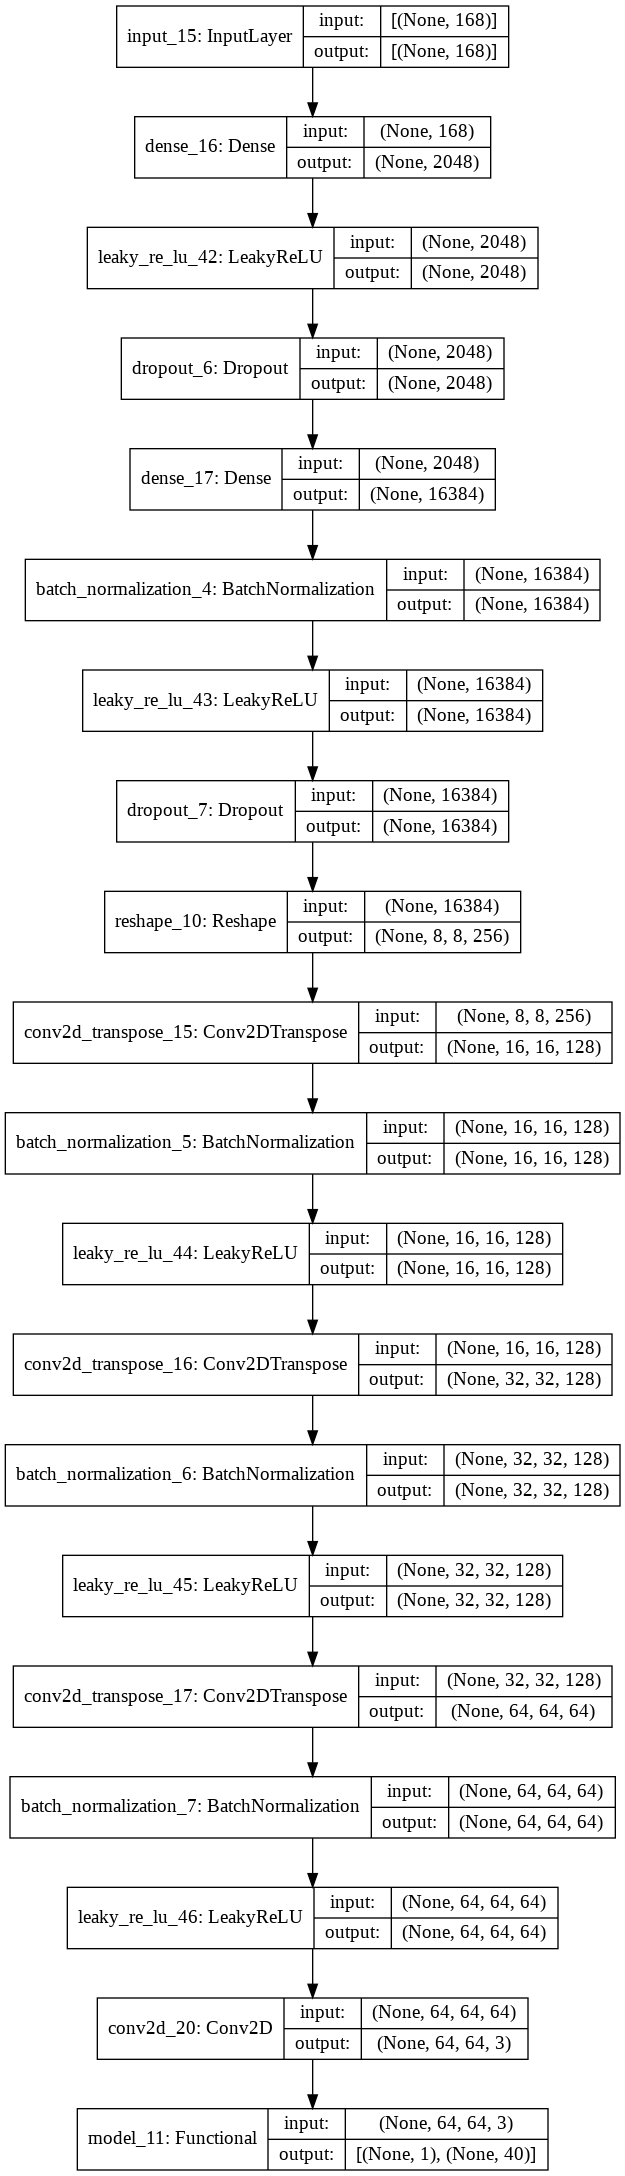

In [ ]:
plot_model(define_gan(generator(latent_dim), discriminator()), to_file='gan.png', show_shapes=True)

### Gan Label Classifier

In [13]:
def generate_latent_point(latent_dim, n_samples, n_classes=2):
  # generate points in the latent space
  X_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = X_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.random.randint(0, n_classes, (n_samples, 40))
  return [z_input, labels]


def generate_fake_samples(generator, latent_dim, real_labels, n_samples):
  # Generate point in Latent Space
  z_input , labels_input = generate_latent_point(latent_dim, n_samples)
  # Pridect Output
  z = np.concatenate((z_input, real_labels), axis=1)
  #images = generator.predict([z_input, real_labels])
  images = generator.predict(z)
  # Create_class_labels
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y

### Training AC_GAN

In [14]:
disc_training_set = real_samples_generator(FACES_PATH, ATTRIBUTE_PATH, 64)
gen_training_set  = real_samples_generator(FACES_PATH, ATTRIBUTE_PATH, 128)

In [15]:
from keras import backend as K

def train(g_model, d_model, gan_model, latent_dim, n_epochs=40, n_batch=128):
  bat_per_epo = int(180000 / n_batch)
  half_batch = int(n_batch / 2)
  d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
  # Enumrating epochs
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      # get randomly selected real samples
      X_real, label_real, y_real = next(disc_training_set)
      # update discriminator model weights
      _, d_loss1, d_acc1 = d_model.train_on_batch(X_real, [y_real, label_real])
      # _, _ = c_model.train_on_batch(X_real, label_real)
      # print(d_model.layers[12].variables)
      # Generate Fake Samples
      # _, label_fake, _ = next(disc_training_set)
      [X_fake, _], y_fake = generate_fake_samples(g_model, latent_dim, label_real, half_batch)
      # Update discriminator model weights
      _, d_loss2, d_acc2 = d_model.train_on_batch(X_fake, [y_fake, label_real])
      # _, _ = c_model.train_on_batch(X_fake, label_real)
      # prepare points in latent space as input for the generator
      [z_input, _] = generate_latent_point(latent_dim, n_batch)
      # prepare real labels for gan
      _, z_label, _ = next(gen_training_set)
      # [_, z_label], _ = generate_real_samples(dataset, n_batch)
      z = np.concatenate((z_input, z_label), axis=1)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      _, g_loss, _ = gan_model.train_on_batch(z, [y_gan, z_label])
      # _      = gan_labe_model.train_on_batch([z_input, z_label], z_label)
      # Taking history of Loss and accuracy of model
      d1_hist.append(d_loss1)
      d2_hist.append(d_loss2)
      g_hist.append(g_loss)
      a1_hist.append(d_acc1)
      a2_hist.append(d_acc2)
      if (j+1) % 100 == 0:
        print('Epochs->{} / Batch->{}'.format(i+1, j+1))
        show_plot(g_model, label_real, latent_dim)
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, i)
  g_model.save('/content/drive/MyDrive/AC_Gan_generator.h5')
  d_model.save('/content/drive/MyDrive/AC_Gan_discriminator.h5')

In [ ]:
# Number of epochs
n_epochs = 40
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = define_gan(g_model, d_model)
train(g_model, d_model, gan_model, latent_dim, n_epochs= n_epochs)

### Testing Section

In [57]:
[z_input, labels_input] = generate_latent_point(128, 25)

att = pd.read_csv(ATTRIBUTE_PATH, index_col='image_id')[:25]
# again replace -1 with 0
att = att.replace(to_replace=-1, value=0)

def plot_generated(examples, n):
  plt.figure(figsize=(10, 10))
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :])
  plt.show()

Choose your custum attribute from form below for generating new Faces.

In [ ]:
#@title Gender

Male = False #@param {type:"boolean"}
att['Male'] = int(Male)

In [ ]:
#@title Age
Young = True #@param {type:"boolean"}
att['Young'] = int(Young)

In [49]:
#@title Hair Color

Bald = False #@param {type:"boolean"}
att['Bald'] = int(Bald)

Black_Hair = True #@param {type:"boolean"}
att['Black_Hair'] = int(Black_Hair)

Blond_Hair = False #@param {type:"boolean"}
att['Blond_Hair'] = int(Blond_Hair)

Brown_Hair = False #@param {type:"boolean"}
att['Brown_Hair'] = int(Brown_Hair)

Gray_Hair = False #@param {type:"boolean"}
att['Gray_Hair'] = int(Gray_Hair)

In [ ]:
#@title Hair

Receding_Hairline = False #@param {type:"boolean"}
att['Receding_Hairline'] = int(Receding_Hairline)

Sideburns =  False #@param {type:"boolean"}
att['Sideburns'] = int(Sideburns)

Bangs = False #@param {type:"boolean"}
att['Bangs'] = int(Bangs)

Straight_Hair = False #@param {type:"boolean"}
att['Straight_Hair'] = int(Straight_Hair)

Wavy_Hair = False #@param {type:"boolean"}
att['Wavy_Hair'] = int(Wavy_Hair)

In [ ]:
#@title Face
Chubby = False #@param {type:"boolean"}
att['Chubby'] = int(Chubby)

Double_Chin = False #@param {type:"boolean"}
att['Double_Chin'] = int(Double_Chin)

High_Cheekbones = False #@param {type:"boolean"}
att['High_Cheekbones'] = int(High_Cheekbones)

Oval_Face = False #@param {type:"boolean"}
att['Oval_Face'] = int(Oval_Face)

Pale_Skin = False #@param {type:"boolean"}
att['Pale_Skin'] = int(Pale_Skin)

Rosy_Cheeks = False #@param {type:"boolean"}
att['Rosy_Cheeks'] = int(Rosy_Cheeks)

Attractive = False #@param {type:"boolean"}
att['Attractive'] = int(Attractive)

In [27]:
#@title Eyes
Narrow_Eyes = False #@param {type:"boolean"}
att['Narrow_Eyes'] = int(Narrow_Eyes)

Arched_Eyebrows = False #@param {type:"boolean"}
att['Arched_Eyebrows'] = int(Arched_Eyebrows)

Bushy_Eyebrows = False #@param {type:"boolean"}
att['Bushy_Eyebrows'] = int(Bushy_Eyebrows)

Eyeglasses = True #@param {type:"boolean"}
att['Eyeglasses'] = int(Eyeglasses)

Bags_Under_Eyes = False #@param {type:"boolean"}
att['Bags_Under_Eyes'] = int(Bags_Under_Eyes)

In [ ]:
#@title Nose
Big_Nose = False #@param {type:"boolean"}
att['Big_Nose'] = int(Big_Nose)

Pointy_Nose = False #@param {type:"boolean"}
att['Pointy_Nose'] = int(Pointy_Nose)

In [58]:
#@title Mouth
Big_Lips = False #@param {type:"boolean"}
att['Big_Lips'] = int(Big_Lips)

Mouth_Slightly_Open = False #@param {type:"boolean"}
att['Mouth_Slightly_Open'] = int(Mouth_Slightly_Open)

Smiling = False #@param {type:"boolean"}
att['Smiling'] = int(Smiling)

In [ ]:
#@title Facial Hair
Goatee = False #@param {type:"boolean"}
att['Goatee'] = int(Goatee)

Mustache = False #@param {type:"boolean"}
att['Mustache'] = int(Mustache)

No_Beard = True #@param {type:"boolean"}
att['No_Beard'] = int(No_Beard)

In [ ]:
#@title Makeup
Heavy_Makeup = False #@param {type:"boolean"}
att['Heavy_Makeup'] = int(Heavy_Makeup)

Wearing_Lipstick = False #@param {type:"boolean"}
att['Wearing_Lipstick'] = int(Wearing_Lipstick)

In [ ]:
#@title Accessories
Wearing_Earrings = False #@param {type:"boolean"}
att['Wearing_Earrings'] = int(Wearing_Earrings)

Wearing_Hat = False #@param {type:"boolean"}
att['Wearing_Hat'] = int(Wearing_Hat)

Wearing_Necklace = False #@param {type:"boolean"}
att['Wearing_Necklace'] = int(Wearing_Necklace)

Wearing_Necktie = False #@param {type:"boolean"}
att['Wearing_Necktie'] = int(Wearing_Necktie)

In [ ]:
#@title Others
Five_o_Clock_Shadow = False #@param {type:"boolean"}
att['Five_o_Clock_Shadow'] = int(Five_o_Clock_Shadow)

Blurry = False #@param {type:"boolean"}
att['Blurry'] = int(Blurry)

In [ ]:
att

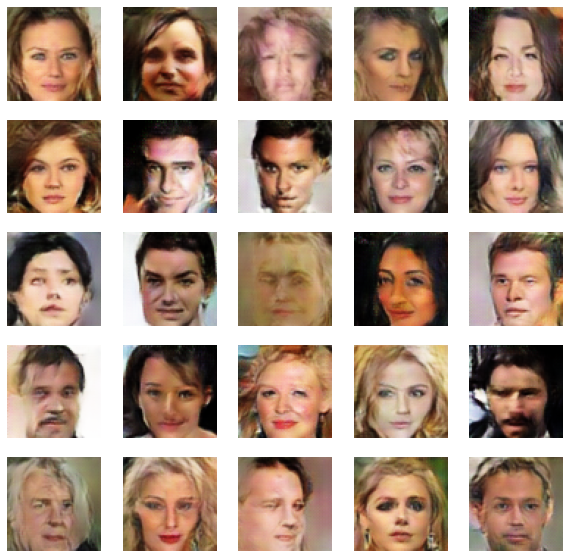

In [59]:
att = np.array(att)
z = np.concatenate((z_input, att), axis=1)   # AC_GAN

generator = load_model('/content/drive/MyDrive/AC_Gan_generator.h5')
X = generator.predict(z)                     # AC_GAN
X = (X + 1) / 2.0
plot_generated(X, 5)

## FID SCORE
finaly, as a comparison, we calculate the FID score. FID score is a metric used to assess the quality of images created by the generator of a generative adversarial network.

In [ ]:
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

In [ ]:
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		new_image = resize(image, new_shape, 0)
		images_list.append(new_image)
	return np.asarray(images_list)

def calculate_fid(act1 , act2):
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  ssdiff = np.sum((mu1 - mu2)**2.0)
  covmean = sqrtm(sigma1.dot(sigma2))
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

inception_model = InceptionV3(include_top=False, pooling='avg')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
def celeba_eval_generator(faces_path, attribute_path, batch_size):
  att = pd.read_csv(attribute_path, index_col='image_id')[180000:]
  att_info = np.random.choice(att.index, 10000, replace=False)
  batched = 0
  while batched < 10000:
    batch_info = att_info[batched: batched + batch_size]
    images_batch = []

    for image_info in batch_info:
      img = Image.open(faces_path + '/' + image_info)
      img = img.crop((25, 45, 153, 173))
      img = img.resize((64, 64))
      img = img.convert('RGB')
      img = np.asarray(img)
      img = img.astype('float32')
      img = (img - 127.5) / 127.5 # Normalization to [-1.,1.]
      images_batch.append(img)

    img_att = np.array(att.loc[batch_info].replace(to_replace=-1, value=0), dtype=np.float32)
    images_batch = np.array(images_batch, dtype=np.float32)
    batched += batch_size
    # y = np.ones((batch_size, 1))
    yield [images_batch, img_att]

In [ ]:
from keras.models import load_model

validation_dataset = celeba_eval_generator(FACES_PATH, ATTRIBUTE_PATH, 100)
ac_generator = load_model('/content/drive/MyDrive/AC_Gan_generator.h5')
c_generator = load_model('/content/drive/MyDrive/cgan_generator.h5')
count = 1

acgan_pred_act = np.array([]).reshape((0, 2048))
acgan_img_act = np.array([]).reshape((0, 2048))
cgan_pred_act = np.array([]).reshape((0, 2048))
cgan_img_act = np.array([]).reshape((0, 2048))

'''
Calculating FID for AC_GAN
'''
print('calculating the ACGAN...')
# calculating the ACGAN
for batch in validation_dataset:
  images = batch[0]
  att    = batch[1]
  batch_size = images.shape[0]
  #print("Batch", count)
  #print("Num samples", batch_size)
  [z_input, _] = generate_latent_point(128, 100)
  z = np.concatenate((z_input, att), axis=1)         # AC_GAN
  # predictions = generator.predict([z_input, att])  # cGAN
  predictions = ac_generator.predict(z)              # AC_GAN
  images1 = scale_images(images, (299, 299, 3))
  images2 = scale_images(predictions, (299, 299, 3))
  a = inception_model.predict(images1)
  b = inception_model.predict(images2)
  acgan_img_act = np.concatenate((img_act, a), axis = 0)
  acgan_pred_act = np.concatenate((pred_act, b), axis = 0)
  count += 1
print('ACGAN calculating finished!')

'''
Calculating FID for cGAN
'''
print('calculating for the CGAN...')
# calculating the CGAN
validation_dataset = celeba_eval_generator(FACES_PATH, ATTRIBUTE_PATH, 100)
count = 1
for batch in validation_dataset:
  images = batch[0]
  att    = batch[1]
  batch_size = images.shape[0]
  #print("Batch", count)
  #print("Num samples", batch_size)
  [z_input, _] = generate_latent_point(128, 100)
  #z = np.concatenate((z_input, att), axis=1)        # AC_GAN
  predictions = c_generator.predict([z_input, att])  # cGAN
  # predictions = generator.predict(z)               # AC_GAN
  images1 = scale_images(images, (299, 299, 3))
  images2 = scale_images(predictions, (299, 299, 3))
  a = inception_model.predict(images1)
  b = inception_model.predict(images2)
  cgan_img_act = np.concatenate((img_act, a), axis = 0)
  cgan_pred_act = np.concatenate((pred_act, b), axis = 0)
  count += 1
print('CGAN calculating finished!')

calculating the ACGAN...
ACGAN calculating finished!
calculating for the CGAN...
CGAN calculating finished!


In [ ]:
print("Calculating score for generation...")
fid_score_acgan = calculate_fid(acgan_img_act, acgan_pred_act)
fid_score_cgan = calculate_fid(cgan_img_act, cgan_pred_act)
print("Score for generation of ACGAN:")
print(np.round(fid_score_acgan, 3))
print("Score for generation of CGAN:")
print(np.round(fid_score_cgan, 3))

Calculating score for generation...
Score for generation of ACGAN:
83.295
Score for generation of CGAN:
108.629


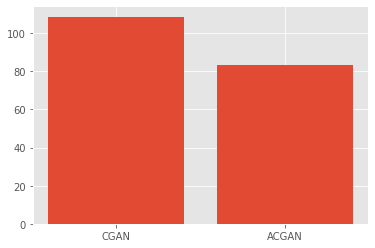

In [ ]:
plt.bar(['CGAN', 'ACGAN'], [np.round(fid_score_cgan, 3), np.round(fid_score_acgan, 3)]);